In [8]:
# primer: generiraj vse povezane grafe z n=6
n = 6
vsi_grafi = [G for G in graphs(n) if G.is_connected()]
print("Število povezanih grafov:", len(vsi_grafi))

def cyclomatic_number(G):
    return G.size() - G.order() + G.connected_components_number()

k = 2
grafi_k = [G for G in vsi_grafi if cyclomatic_number(G) == k]
print("Število grafov z µ(G)=2:", len(grafi_k))

def all_simple_paths(G, start, end, visited=None):
    if visited is None:
        visited = []
    visited = visited + [start]
    if start == end:
        return [visited]
    paths = []
    for neighbor in G.neighbors(start):
        if neighbor not in visited:
            newpaths = all_simple_paths(G, neighbor, end, visited)
            for p in newpaths:
                paths.append(p)
    return paths

def subpath_number(G):
    n = 0
    V = list(G.vertices())
    for i in range(len(V)):
        for j in range(i, len(V)):
            n += len(all_simple_paths(G, V[i], V[j]))
    return n

for G in grafi_k:
    print(f"|V|={G.order()}, |E|={G.size()}, µ(G)={cyclomatic_number(G)}, p_n(G)={subpath_number(G)}")


Število povezanih grafov: 112
Število grafov z µ(G)=2: 19
|V|=6, |E|=7, µ(G)=2, p_n(G)=46
|V|=6, |E|=7, µ(G)=2, p_n(G)=52
|V|=6, |E|=7, µ(G)=2, p_n(G)=48
|V|=6, |E|=7, µ(G)=2, p_n(G)=43
|V|=6, |E|=7, µ(G)=2, p_n(G)=51
|V|=6, |E|=7, µ(G)=2, p_n(G)=49
|V|=6, |E|=7, µ(G)=2, p_n(G)=48
|V|=6, |E|=7, µ(G)=2, p_n(G)=46
|V|=6, |E|=7, µ(G)=2, p_n(G)=47
|V|=6, |E|=7, µ(G)=2, p_n(G)=48
|V|=6, |E|=7, µ(G)=2, p_n(G)=56
|V|=6, |E|=7, µ(G)=2, p_n(G)=54
|V|=6, |E|=7, µ(G)=2, p_n(G)=55
|V|=6, |E|=7, µ(G)=2, p_n(G)=53
|V|=6, |E|=7, µ(G)=2, p_n(G)=54
|V|=6, |E|=7, µ(G)=2, p_n(G)=51
|V|=6, |E|=7, µ(G)=2, p_n(G)=52
|V|=6, |E|=7, µ(G)=2, p_n(G)=48
|V|=6, |E|=7, µ(G)=2, p_n(G)=43


In [56]:
# === Projekt: Subpath number pri grafih z danim ciklomatskim številom ===

import itertools
from sage.all import *
import pandas as pd


# -------------------------------
# Funkcija za ciklomatsko število
# -------------------------------
def cyclomatic_number(G):
    return G.size() - G.order() + G.connected_components_number()

# -------------------------------
# Funkcija za štetje vseh enostavnih poti
# -------------------------------
def all_simple_paths(G, start, end, visited=None):
    if visited is None:
        visited = []
    visited = visited + [start]
    if start == end:
        return [visited]
    paths = []
    for neighbor in G.neighbors(start):
        if neighbor not in visited:
            newpaths = all_simple_paths(G, neighbor, end, visited)
            for p in newpaths:
                paths.append(p)
    return paths

def subpath_number(G):
    """Vrne skupno število enostavnih poti (vključno z dolžino 0)."""
    V = list(G.vertices())
    n_paths = 0
    for i in range(len(V)):
        for j in range(i, len(V)):
            n_paths += len(all_simple_paths(G, V[i], V[j]))
    return n_paths

# -------------------------------
# Glavni izračun
# -------------------------------
rezultati = []  # seznam (n, µ, subpath_number)

# Za n = 3 do 7 (manjše vrednosti, da se ne zatakne)
for n in range(3, 9):
    print(f"\nObdelujem vse povezane grafe z n = {n} vozlišči ...")
    for G in graphs(n):
        if not G.is_connected():
            continue
        mu = cyclomatic_number(G)
        pn = subpath_number(G)
        rezultati.append((n, mu, pn))

print("\n--- Izračun končan ---")

# Pretvori rezultate v Sage DataFrame
df = pd.DataFrame(rezultati, columns=["n", "µ(G)", "p_n(G)"])


# Izračunaj minimalni in maksimalni subpath number za vsako kombinacijo (n, µ)
tabela = (
    df.groupby(["n", "µ(G)"])
    .agg(min_pn=("p_n(G)", "min"), max_pn=("p_n(G)", "max"), count=("p_n(G)", "count"))
    .reset_index()
)

# Izpiši tabelo rezultatov
print("\nTabela ekstremov (min / max subpath number):")
show(tabela)

# Shranimo tabelo kot CSV
tabela.to_csv("rezultati_subpath.csv", index=False)
print("\nRezultati shranjeni v datoteko 'rezultati_subpath.csv'.")


Obdelujem vse povezane grafe z n = 3 vozlišči ...

Obdelujem vse povezane grafe z n = 4 vozlišči ...

Obdelujem vse povezane grafe z n = 5 vozlišči ...

Obdelujem vse povezane grafe z n = 6 vozlišči ...

Obdelujem vse povezane grafe z n = 7 vozlišči ...

Obdelujem vse povezane grafe z n = 8 vozlišči ...

--- Izračun končan ---

Tabela ekstremov (min / max subpath number):


n  µ(G) min_pn max_pn  count
0   3     0      6      6      1
1   3     1      9      9      1
2   4     0     10     10      2
3   4     1     15     16      2
4   4     2     23     23      1
.. ..   ...    ...    ...    ...
57  8    17  17618  21680     11
58  8    18  24468  27099      5
59  8    19  32949  34058      2
60  8    20  43061  43061      1
61  8    21  54804  54804      1

[62 rows x 5 columns]


Rezultati shranjeni v datoteko 'rezultati_subpath.csv'.


In [26]:
# === Projekt: Subpath number pri grafih z danim ciklomatskim številom ===
# Delo v CoCalc-u (SageMath kernel)

import itertools
from sage.all import *
import pandas as pd


# -------------------------------
# Funkcija za ciklomatsko število
# -------------------------------
def cyclomatic_number(G):
    """Vrne ciklomatsko število grafa G."""
    return G.size() - G.order() + G.connected_components_number()


# -------------------------------
# Funkcija za štetje vseh enostavnih poti
# -------------------------------
def all_simple_paths(G, start, end, visited=None):
    """Rekurzivno poišče vse enostavne poti med start in end."""
    if visited is None:
        visited = []
    visited = visited + [start]
    if start == end:
        return [visited]
    paths = []
    for neighbor in G.neighbors(start):
        if neighbor not in visited:
            newpaths = all_simple_paths(G, neighbor, end, visited)
            for p in newpaths:
                paths.append(p)
    return paths


def subpath_number(G):
    """Vrne skupno število enostavnih poti (vključno z dolžino 0)."""
    V = list(G.vertices())
    n_paths = 0
    for i in range(len(V)):
        for j in range(i, len(V)):
            n_paths += len(all_simple_paths(G, V[i], V[j]))
    return n_paths


# -------------------------------
# Glavni izračun
# -------------------------------
rezultati = []  # seznam (n, µ, subpath_number)

# Za n = 3 do 8
for n in range(3, 9):
    print(f"\nObdelujem grafe z n = {n} vozlišči ...")

    max_edges = n * (n - 1) // 2  # maksimalno število povezav

    # Za vsa možna ciklomatska števila µ
    for mu in range(0, max_edges - n + 2):
        m = mu + n - 1  # izpeljano iz µ = m - n + 1

        if m > max_edges:
            continue

        print(f"  → µ = {mu}, m = {m}")

        # Generiramo vse neizomorfne grafe z n vozlišči in m povezavami
        for G in graphs.nauty_geng(f"{n} {m}:{m}"):
            if not G.is_connected():
                continue

            pn = subpath_number(G)
            rezultati.append((n, mu, pn))

print("\n--- Izračun končan ---")

# Pretvori rezultate v DataFrame
df = pd.DataFrame(rezultati, columns=["n", "µ(G)", "p_n(G)"])

# Izračunaj minimalni in maksimalni subpath number za vsako kombinacijo (n, µ)
tabela = (
    df.groupby(["n", "µ(G)"])
    .agg(min_pn=("p_n(G)", "min"), max_pn=("p_n(G)", "max"), count=("p_n(G)", "count"))
    .reset_index()
)

# Izpiši tabelo rezultatov
print("\nTabela1 ekstremov (min / max subpath number):")
show(tabela)

# Shranimo tabelo kot CSV
tabela.to_csv("rezultati_subpath1.csv", index=False)
print("\nRezultati shranjeni v datoteko 'rezultati_subpath1.csv'.")



Obdelujem grafe z n = 3 vozlišči ...
  → µ = 0, m = 2
  → µ = 1, m = 3

Obdelujem grafe z n = 4 vozlišči ...
  → µ = 0, m = 3
  → µ = 1, m = 4
  → µ = 2, m = 5
  → µ = 3, m = 6

Obdelujem grafe z n = 5 vozlišči ...
  → µ = 0, m = 4
  → µ = 1, m = 5
  → µ = 2, m = 6
  → µ = 3, m = 7
  → µ = 4, m = 8
  → µ = 5, m = 9
  → µ = 6, m = 10

Obdelujem grafe z n = 6 vozlišči ...
  → µ = 0, m = 5
  → µ = 1, m = 6
  → µ = 2, m = 7
  → µ = 3, m = 8
  → µ = 4, m = 9
  → µ = 5, m = 10
  → µ = 6, m = 11
  → µ = 7, m = 12
  → µ = 8, m = 13
  → µ = 9, m = 14
  → µ = 10, m = 15

Obdelujem grafe z n = 7 vozlišči ...
  → µ = 0, m = 6
  → µ = 1, m = 7
  → µ = 2, m = 8
  → µ = 3, m = 9
  → µ = 4, m = 10
  → µ = 5, m = 11
  → µ = 6, m = 12
  → µ = 7, m = 13
  → µ = 8, m = 14
  → µ = 9, m = 15
  → µ = 10, m = 16
  → µ = 11, m = 17
  → µ = 12, m = 18
  → µ = 13, m = 19
  → µ = 14, m = 20
  → µ = 15, m = 21

Obdelujem grafe z n = 8 vozlišči ...
  → µ = 0, m = 7
  → µ = 1, m = 8
  → µ = 2, m = 9
  → µ = 3, m = 

n  µ(G) min_pn max_pn  count
0   3     0      6      6      1
1   3     1      9      9      1
2   4     0     10     10      2
3   4     1     15     16      2
4   4     2     23     23      1
.. ..   ...    ...    ...    ...
57  8    17  17618  21680     11
58  8    18  24468  27099      5
59  8    19  32949  34058      2
60  8    20  43061  43061      1
61  8    21  54804  54804      1

[62 rows x 5 columns]


Rezultati shranjeni v datoteko 'rezultati_subpath1.csv'.



>>> Obdelujem n = 3


TypeError: 'NoneType' object is not iterable

In [1]:
import itertools
from sage.all import *
import pandas as pd
import os

# --------------------------------------------------
# Funkcija za ciklomatsko število
# --------------------------------------------------
def cyclomatic_number(G):
    return G.size() - G.order() + G.connected_components_number()

# --------------------------------------------------
# Funkcija za štetje enostavnih poti
# --------------------------------------------------
def all_simple_paths(G, start, end, visited=None):
    if visited is None:
        visited = []
    visited = visited + [start]
    if start == end:
        return [visited]
    paths = []
    for nei in G.neighbors(start):
        if nei not in visited:
            newp = all_simple_paths(G, nei, end, visited)
            paths.extend(newp)
    return paths

def subpath_number(G):
    V = G.vertices()
    total = 0
    for i in range(len(V)):
        for j in range(i, len(V)):
            total += len(all_simple_paths(G, V[i], V[j]))
    return total


# --------------------------------------------------
# Glavni izračun – z enoličnim zapisom grafov (graph6)
# --------------------------------------------------

os.makedirs("slike_min", exist_ok=True)
os.makedirs("slike_max", exist_ok=True)

rezultat_vrstice = []   # za CSV

for n in range(3, 9):
    print(f"\nObdelujem vse povezane grafe z n = {n} vozlišči ...")

    po_mu = {}   # mu : list of (pn, G)

    for G in graphs(n):
        if not G.is_connected():
            continue

        mu = cyclomatic_number(G)
        pn = subpath_number(G)

        if mu not in po_mu:
            po_mu[mu] = []
        po_mu[mu].append((pn, G))

    # min/max
    for mu in sorted(po_mu.keys()):
        seznam = sorted(po_mu[mu], key=lambda x: x[0])

        min_pn, G_min = seznam[0]
        max_pn, G_max = seznam[-1]

        # --- slike ---
        min_slika = f"slike_min/graf_min_n{n}_mu{mu}.png"
        max_slika = f"slike_max/graf_max_n{n}_mu{mu}.png"

        G_min.plot().save(min_slika)
        G_max.plot().save(max_slika)

        # --- enoličen zapis grafa (graph6) ---
        g6_min = G_min.graph6_string()
        g6_max = G_max.graph6_string()

        # --- zapišemo v tabelo ---
        rezultat_vrstice.append([n, mu, min_pn, max_pn,
                                 min_slika, max_slika,
                                 g6_min, g6_max])

print("\n--- Izračun končan ---")


# --------------------------------------------------
# CSV izpis
# --------------------------------------------------

df = pd.DataFrame(
    rezultat_vrstice,
    columns=[
        "n",
        "µ(G)",
        "min p_n(G)",
        "max p_n(G)",
        "slika_min",
        "slika_max",
        "graph6_min",
        "graph6_max"
    ]
)

df.to_csv("rezultati_subpath_grafi_enolicni.csv", index=False)



Obdelujem vse povezane grafe z n = 3 vozlišči ...

Obdelujem vse povezane grafe z n = 4 vozlišči ...

Obdelujem vse povezane grafe z n = 5 vozlišči ...

Obdelujem vse povezane grafe z n = 6 vozlišči ...

Obdelujem vse povezane grafe z n = 7 vozlišči ...

Obdelujem vse povezane grafe z n = 8 vozlišči ...

--- Izračun končan ---


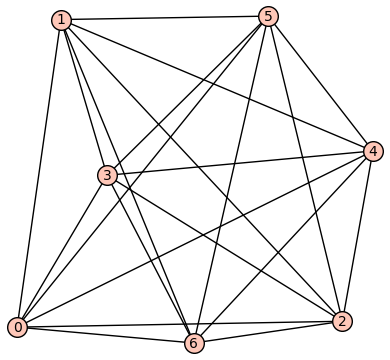

In [ ]:
# risanje konkretnih grafov

g6 = "F~~~w"       # tvoj graph6 niz
G = Graph(g6)     # rekonstruira graf
G.show()  